In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import csv
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
import sys
import random
import pandas as pd
from rerank_score_cands_new import load_cands
import numpy as np
from comet import download_model, load_from_checkpoint
import pickle

csv.field_size_limit(sys.maxsize)


2022-10-14 19:49:20.272043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-14 19:49:20.272064: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


131072

In [2]:
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.cuda.set_device(1)

In [ ]:
# Encoder-Decoder Model Embedding, Add a Weighted Layer at the end that leads to regression
class XLMCometRegressor(nn.Module):
    
    def __init__(self, drop_rate=0.2):
        # TODO should we be freezing layers?
        super().__init__()
        
        self.xlmroberta = AutoModel.from_pretrained('xlm-roberta-base')
        # Num labels 1 should just indicate regression (?)
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(self.xlmroberta.config.hidden_size, 1))
        self.to(device)
        
    def forward(self, input_ids, attention_masks):
        # don't finetune xlmroberta model
        with torch.no_grad():
            outputs = self.xlmroberta(input_ids, attention_mask=attention_masks, encoder_attention_mask=attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs
    
model = XLMCometRegressor(drop_rate=0.2)

Predicting:  38%|█████████████████████████████████                                                       | 6/16 [00:53<01:28,  8.85s/it]


In [ ]:
model.load_state_dict(torch.load("./torchsaved/comestim8.pt"))

In [2]:
# loads in a lot of french->english data
def load_lpair_data():
    fr_raw = []
    en_raw = []
    with open('translation_data/news-commentary-v9.fr-en.fr') as f:
        for i in range(0, 80000):
            fr_raw.append(f.readline())
        #fr_raw.remove("")
    with open('translation_data/news-commentary-v9.fr-en.en') as f:
        for i in range(0, 80000):
            en_raw.append(f.readline())
        #en_raw.remove("")
    res = []
    for fr, en in zip(fr_raw, en_raw):
        tmp = {}
        tmp['fr'] = fr
        tmp['en'] = en
        res.append(tmp)
    random.shuffle(res)
    tmpdf = pd.DataFrame(res)
    return tmpdf

In [4]:
golddf = load_lpair_data()

In [6]:
golddf

,fr,en
0,Puisque les États ne pourront agir seuls et ne...,But as the states won’t be able to do everythi...
1,"A ces éléments déjà anciens, s'est ajouté ce q...","To this old brew, new ingredients have been ad..."
2,"Selon cette hypothèse, si le taux d'inflation ...","Second, reformers should not presume that offi..."
3,"NEW HAVEN – Une fois encore, la Chine s’est jo...",Large buffers of saving (53% of GDP) and forei...
4,Mais l'absence d'une opposition forte a favori...,"Although the current governing coalition, cons..."
...,...,...
79995,Au moins une partie du problème tient au fait ...,At least part of the problem is that it is dea...
79996,"Mais, personne ne les oblige à accepter cet ar...",The special master would not be a fellow Calif...
79997,Car Chypre reste une île divisée.\n,This is because Cyprus remains a divided islan...
79998,"Nourrir la population mondiale, la protéger d’...","The challenges of feeding the world, keeping i..."


In [6]:
d1 = pd.read_csv('./crit_err_data/goldlabels.txt', sep='\t')

In [7]:
d1

,en-de,REFERENCE,2407,NOT
0,en-de,REFERENCE,7270,ERR
1,en-de,REFERENCE,3532,NOT
2,en-de,REFERENCE,374,NOT
3,en-de,REFERENCE,4876,ERR
4,en-de,REFERENCE,5419,ERR
...,...,...,...,...
994,en-de,REFERENCE,8507,NOT
995,en-de,REFERENCE,934,NOT
996,en-de,REFERENCE,6717,ERR
997,en-de,REFERENCE,6708,NOT


In [3]:
golddf = pd.read_csv('./processeddata/golddata.csv')

In [4]:
golddf

,Unnamed: 0,fr,en,scores
0,0,Puisque les États ne pourront agir seuls et ne...,But as the states won’t be able to do everythi...,0.969682
1,1,"A ces éléments déjà anciens, s'est ajouté ce q...","To this old brew, new ingredients have been ad...",1.015768
2,2,"Selon cette hypothèse, si le taux d'inflation ...","Second, reformers should not presume that offi...",0.954492
3,3,"NEW HAVEN – Une fois encore, la Chine s’est jo...",Large buffers of saving (53% of GDP) and forei...,0.911272
4,4,Mais l'absence d'une opposition forte a favori...,"Although the current governing coalition, cons...",0.893119
...,...,...,...,...
49995,49995,Les négociations sur le changement climatique ...,The engineering solution is to keep a large am...,0.894210
49996,49996,Mettant en évidence l'inadéquation du Traité d...,So a concerted effort is needed by outside pow...,0.910272
49997,49997,Nous devons mettre fin à nos anciennes animosi...,We should put our ancient animosities behind u...,1.036713
49998,49998,Des points de vue différents sur la manière de...,"In Germany, the Mohn family dismissed the lead...",0.926789


In [4]:
# Load data with COMET scores that we can regress on
#df = load_lpair_data()
cometmodel = "wmt20-comet-da"
comet_path = download_model(cometmodel, "./cometmodel")
comet = load_from_checkpoint(comet_path).to(device)

wmt20-comet-da is already in cache.
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.


In [5]:
def make_com_inputs(cands):
    alldata = []
    for c in cands:
        ind = 0
        for cand in c['cands']:
            tmp = {}
            tmp['inp'] = c['src']
            tmp['ref'] = c['ref']
            tmp['hyp'] = cand
            tmp['scores'] = c['cometscores'][ind]
            alldata.append(tmp)
            ind+=1
    return alldata

def get_comet_scores(hyps, srcs, refs):
    cometqe_input = [{"src": src, "mt": mt, "ref":ref} for src, mt, ref in zip(srcs, hyps, refs)]
    # sentence-level and corpus-level COMET
    outs = []
    for i in range(0, int(len(srcs)/2048)):
        p = comet.predict(
            cometqe_input[i*2048:(i+1)*2048], batch_size=128, progress_bar=True,
            gpus=1
        )
        outs.extend(p[0])
        del p
        torch.cuda.empty_cache()
    return outputs    

In [6]:
frdata = pd.read_csv("processeddata/cpfdata.csv")

In [7]:
frdata = frdata.dropna()

In [8]:
a=torch.rand(100).cuda() 

In [ ]:
sco = get_comet_scores(frdata['hyp'], frdata['src'], frdata['ref'])
frdata['score'] = sco
frdata.to_csv("processeddata/cpfdata.csv")

In [ ]:
gdata = pd.read_csv("processeddata/cpgdata.csv")

In [ ]:
gdata = gdatata.dropna()

In [ ]:
sco = get_comet_scores(gdata['hyp'], gdata['src'], gdata['ref'])
gdata['score'] = sco
gdata.to_csv("processeddata/cpgdata.csv")

In [ ]:
import json

In [8]:
with open("rerank_outputs/post2post1explodedmtn1_fr-en_bfs_recom_4_-1_False_0.4_True_False_4_5_rcb_0.9_0.0_0.9.json", "r") as f:
    ldata = json.load(f)

In [ ]:
ldata['data'][0]['cometscores']

In [20]:
cominputs = make_com_inputs(ldata['data'])

In [21]:
inpdf = pd.DataFrame(cominputs)

In [22]:
inpdf

,inp,ref,hyp,scores
0,La police française arrêtera les supporters d'...,French Police to Arrest Anderlecht Supporters ...,French police to arrest Anderlecht supporters ...,0.637964
1,La police française arrêtera les supporters d'...,French Police to Arrest Anderlecht Supporters ...,French police to arrest Anderlecht supporters ...,0.618924
2,La police française arrêtera les supporters d'...,French Police to Arrest Anderlecht Supporters ...,French police to arrest Anderlecht supporters ...,0.302696
3,La police française arrêtera les supporters d'...,French Police to Arrest Anderlecht Supporters ...,French police to arrest Anderlecht supporters ...,0.257949
4,La police française arrêtera les supporters d'...,French Police to Arrest Anderlecht Supporters ...,French police to arrest Anderlecht supporters ...,0.756469
...,...,...,...,...
237836,Des scientifiques britanniques ont déclaré que...,British scientists said the results were inter...,British scientists said the results are intere...,0.838725
237837,Des scientifiques britanniques ont déclaré que...,British scientists said the results were inter...,British scientists stated that the results are...,0.335234
237838,Des scientifiques britanniques ont déclaré que...,British scientists said the results were inter...,British scientists have said that the results ...,0.504879
237839,Des scientifiques britanniques ont déclaré que...,British scientists said the results were inter...,British scientists said that the results are i...,0.444502


In [ ]:
with torch.no_grad():
    scores = get_comet_scores(golddf['en'], golddf['fr'], golddf['en'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Predicting:  97%|████████████████████████████████████████████████████████████████████████████████████▌  | 380/391 [15:18<00:26,  2.42s/it]

In [23]:
#golddf['scores']=scores
inpdf.to_csv('processeddata/testinpdata.csv')

In [ ]:
#com_inps = make_com_inputs(bcands)
#com_inps.extend(make_com_inputs(lcands)[:40000])

In [5]:
distill_df = pd.read_csv('distill_cometdata_1.csv')
#rand_df = pd.read_csv('distill_cometdata_rand.csv')
#distill_df = distill_df.append(rand_df, ignore_index=True)


In [6]:
distill_df

,Unnamed: 0,inp,ref,hyp,scores
0,0,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l...",-0.349685
1,1,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l...",-0.609029
2,2,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l...",-0.344984
3,3,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l...",-0.205078
4,4,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l...",-0.323497
...,...,...,...,...,...
79995,79995,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,Men are being killed in the street or even at ...,0.556703
79996,79996,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,"Men are killed on the streets or even at home,...",0.774939
79997,79997,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,Men are being killed in the streets or even at...,0.754243
79998,79998,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,Men are being killed in the streets or even at...,0.730451


In [3]:
xlm_tok = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [4]:
xlm_tok(distill_df['inp'][0])

{'input_ids': [0, 1572, 44764, 8, 405, 10644, 8, 195395, 7, 85309, 7, 4, 199, 144045, 1148, 4, 45, 42182, 4, 199, 384, 57753, 7162, 82, 199, 132702, 7162, 15, 122061, 108, 15324, 5365, 224, 5406, 7438, 82, 224, 24727, 63614, 6, 94416, 2045, 9044, 106747, 7, 578, 38747, 51, 17019, 15889, 60013, 8, 59539, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [4]:
# construct inputs from dataframe
def get_inputs(inpdf):
    xinp = []
    yinp = []
    maskinp = []
    
    for index, row in inpdf.iterrows():
        if index%1000==0:
            print(index)
        #print(row['c1'], row['c2'])
        # will need to make a custom mask (maybe) so that inputs from both languages are encoded separately
        toktmp = xlm_tok(row['inp']).input_ids
        lent = len(toktmp)
        hyptmp = xlm_tok(row['hyp']).input_ids
        toktmp.extend(hyptmp)
        mask = torch.zeros(len(toktmp), len(toktmp))
        # should set upper left and bottom right quadrants to 1, mask other stuff
        # TODO make different types of masks. 
        mask[:lent, :lent] = 1
        mask[lent:, lent:] = 1
        xinp.append(toktmp)
        maskinp.append(mask)
        yinp.append(row['scores'])
    return xinp, yinp, maskinp

In [6]:
from sklearn.utils import shuffle
distill_df = shuffle(distill_df)
distill_df = distill_df.reset_index(drop=True)

In [ ]:
#inps = pd.DataFrame(com_inps)
xdata, ydata, mdata = get_inputs(distill_df)

In [6]:
cut = int(len(xdata)*.9)
xtrain, ytrain, mtrain = xdata[:cut], ydata[:cut], mdata[:cut]
xtest, ytest, mtest = xdata[cut:], ydata[cut:], mdata[cut:]

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class RegressionDataset(Dataset):
    def __init__(self, sentences, labels, masks):
        assert len(sentences) == len(labels)
        self.sentences = sentences
        self.labels = labels
        self.masks = masks

    def __getitem__(self, i):
        return self.sentences[i], self.labels[i], self.masks[i]

    def __len__(self):
        return len(self.sentences)

def collate_custom(datafull):
    #print(len(datafull[0]))
    data = [torch.tensor(d[0]) for d in datafull]
    masdata=  [d[2] for d in datafull]
    labels = [d[1] for d in datafull]
    max_len = max([x.squeeze().numel() for x in data])
    data = [torch.nn.functional.pad(x, pad=(0, max_len - x.numel()), mode='constant', value=0) for x in data]
    data = torch.stack(data).to(device)
    masdata = [torch.nn.functional.pad(x, pad=(0, max_len - x[0].numel(), 0, max_len - x[0].numel()), mode='constant', value=0) for x in masdata]
    masdata = torch.stack(masdata).to(device)
    return data, torch.tensor(labels).to(device), masdata

testloader = DataLoader(RegressionDataset(xtest, ytest, mtest), batch_size=32, shuffle=False, collate_fn=collate_custom)
trainloader = DataLoader(RegressionDataset(xtrain, ytrain, mtrain), batch_size=32, shuffle=False, collate_fn=collate_custom)

In [7]:
iter_loader = iter(trainloader)
batch1 = next(iter_loader)

NameError: name 'trainloader' is not defined

In [65]:
batch1[1].dim()

3

In [11]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

from transformers import get_linear_schedule_with_warmup
epochs = 5
total_steps = len(trainloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

loss_function = nn.MSELoss()



In [8]:
from torch.nn.utils.clip_grad import clip_grad_norm
def train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
    print("Total steps :", total_steps)
    for epoch in range(epochs):
        print("EPOCH ", epoch)
        print("-----")
        best_loss = 1e10
        model.train()
        for step, batch in enumerate(train_dataloader): 
            batch_inputs, batch_labels, batch_masks = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)           
            loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())
            if step%500==0:
                print(loss)  
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
                
    return model

In [22]:
def evaluate(model, loss_function, test_dataloader, device):
    model.eval()
    test_loss, test_r2 = [], []
    pdistr = []
    for batch in test_dataloader:
        batch_inputs, batch_labels, batch_masks = \
                                 tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        pdistr.extend(outputs)
        loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())
        test_loss.append(loss.item())
        r2 = r2_score(outputs, batch_labels)
        test_r2.append(r2.item())
    return test_loss, test_r2, outputs

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [25]:
model = train(model, optimizer, scheduler, loss_function, epochs, 
              trainloader, device, clip_value=2)

Total steps : 22500
EPOCH  0
-----
tensor(0.8062, device='cuda:1', grad_fn=<MseLossBackward0>)


/tmp/ipykernel_3425469/3592679433.py:20: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  clip_grad_norm(model.parameters(), clip_value)


tensor(0.6436, device='cuda:1', grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

In [78]:
torch.save(model.state_dict(), "torchsaved/mv1.pt")

In [23]:
with torch.no_grad():
    distr, r2, outpreds = evaluate(model, loss_function, testloader, device)

In [ ]:
distr[:100]

In [17]:
import matplotlib.pyplot as plt

(array([ 13.,  45., 120., 111.,  97.,  68.,  28.,  15.,   2.,   1.]),
 array([0.50940275, 0.58492422, 0.66044569, 0.73596716, 0.81148863,
        0.8870101 , 0.96253157, 1.03805304, 1.1135745 , 1.18909597,
        1.26461744]),
 <BarContainer object of 10 artists>)

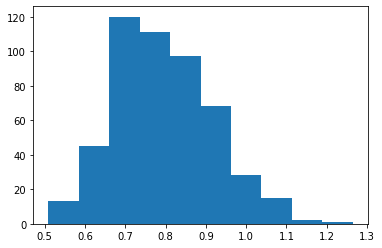

In [18]:
import matplotlib.pyplot as plt
plt.hist(distr)

In [5]:
 ### ### Older code, TODO clean up this notebook ### ###
def save_cometqe_data(md, xd, yd):
    # save data into a pickle file
    with open('processeddata/commasks.pkl', 'wb') as f:
        pickle.dump(md, f)

    with open('processeddata/cominps.pkl', 'wb') as f:
        pickle.dump(xd, f)

    with open('processeddata/comlabels.pkl', 'wb') as f:
        pickle.dump(yd, f)

def load_cometqe_data():
    with open('processeddata/commasks.pkl', 'rb') as f:
        masks = pickle.load(f)

    with open('processeddata/cominps.pkl', 'rb') as f:
        xinps = pickle.load(f)

    with open('processeddata/comlabels.pkl', 'rb') as f:
        yinps = pickle.load(f)
    return masks, xinps, yinps

mdata, xdata, ydata = load_cometqe_data()

In [1]:
xdata

NameError: name 'xdata' is not defined

In [6]:
xdata = [torch.tensor(x) for x in xdata]

In [ ]:
torch.save(xdata, 'processeddata/comet_x.pt')
torch.save(mdata, 'processeddata/comet_m.pt')
torch.save(torch.tensor(ydata), 'processeddata/comet_y.pt')

In [19]:
xlm_tok.decode(1)

'<pad>'

In [9]:
m = torch.ones(3, 3)
nn.functional.pad(m, (0, 1, 0, 1))

tensor([[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [0., 0., 0., 0.]])

In [41]:
input_tensor = torch.tensor(xdata)
mask_tensor = torch.tensor(mdata)
labels_tensor = torch.tensor(ydata)
dataset = TensorDataset(input_tensor, mask_tensor, 
                        labels_tensor)

ValueError: expected sequence of length 70 at dim 1 (got 111)

In [33]:
# do train test split
splitval = 0.8*xdata
tr_xd, tr_yd, tr_mask = xdata[]
# make dataloaders
batch_size = 32
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader



tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

In [25]:
xlm_tok.decode(xdata[0])

'<s> Manquant de ce type de menaces externes, les liens entre, disons, les Tchèques et les Slovaques (pour ne rien dire des Serbes et des Croates!), sont trop faibles pour garantir un niveau national commun de gouvernement.</s><s> In the absence of such external threats, the links between, say, the Czechs and Slovaks (not to mention the Serbs and Croats</s>'

In [22]:
inps['hyp'] = np.random.permutation(inps['hyp'])

In [20]:
distill_df

,Unnamed: 0,inp,ref,hyp,scores
0,0,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l...",-0.349685
1,1,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l...",-0.609029
2,2,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l...",-0.344984
3,3,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l...",-0.205078
4,4,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l...",-0.323497
...,...,...,...,...,...
159995,79995,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,"In less turbulent times than today, nobody was...",-1.177833
159996,79996,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,"""We really hope that this type of vaccine stra...",-1.197750
159997,79997,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,"On Monday, 20,000 police will be deployed befo...",-1.263306
159998,79998,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,The United Nations is there to protect States ...,-1.213348


In [20]:
random.shuffle(randhyps)


KeyboardInterrupt



In [ ]:
inps['hyp'] = randhyps

In [24]:
scores = get_comet_scores(inps['hyp'], inps['inp'], inps['ref'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Predicting: 100%|███████████████████████████████████████████████████████████████████████████████████████| 625/625 [14:01<00:00,  1.35s/it]


In [25]:
inps['scores'] = scores[0]

In [26]:
inps.to_csv('distill_cometdata_rand.csv')

In [21]:
#df.to_csv("translation_data/processed/en_de_10000.csv")

In [9]:
# Maybe introduce contrastive data that's completely unrelated

In [14]:
# Finetune data on DataLoader Set
inps

,inp,ref,hyp
0,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l..."
1,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l..."
2,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l..."
3,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l..."
4,"Manquant de ce type de menaces externes, les l...","Lacking such external threats, the ties betwee...","In the absence of such external threats, the l..."
...,...,...,...
79995,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,Men are being killed in the street or even at ...
79996,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,"Men are killed on the streets or even at home,..."
79997,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,Men are being killed in the streets or even at...
79998,Des hommes sont abattus en pleine rue ou même ...,People are attacked in the street and even at ...,Men are being killed in the streets or even at...


In [13]:
# Test model
